# VIX Cross Asset Volatility With Implied Correlation

# Packages

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas_datareader as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

In [2]:
FIGSIZE = (20,6)

# Helper Functions

In [3]:
def _get_z_score(df):
    return(df.assign(
        df_rtn = lambda x: x.value.pct_change(),
        df_mean = lambda x: x.df_rtn.rolling(window = 120).mean(),
        df_std = lambda x: x.df_rtn.rolling(window = 120).std(),
        z_score = lambda x: (x.df_mean - x.df_rtn) / x.df_std).
        drop(columns = ["df_mean", "df_std", "df_rtn"]))

# Path Management

In [4]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
out_path = os.path.join(parent_path, "out")

if os.path.exists(data_path) == False: os.makedirs(data_path)
if os.path.exists(out_path) == False: os.makedirs(out_path)

# Read Data

In [5]:
df_yf = pd.read_parquet(
    path = os.path.join(data_path, "yf.parquet"),
    engine = "pyarrow")

df_corr = pd.read_parquet(
    path = os.path.join(data_path, "corr.parquet"))

# Incorporate Dispersion into the measure

In [6]:
df_vol_corr = (df_yf.query(
    "variable == 'VIX'").
    rename(columns = {
        "variable": "volatility_ticker",
        "value": "volatility_measure"}).
    merge(
        df_corr, how = "inner", on = ["date"]).
    rename(columns = {
        "ticker": "corr_ticker",
        "value": "corr_measure"}).
    drop(columns = ["field"]).
    assign(vol_corr = lambda x: x.volatility_measure / (x.corr_measure / 100)).
    set_index("date"))

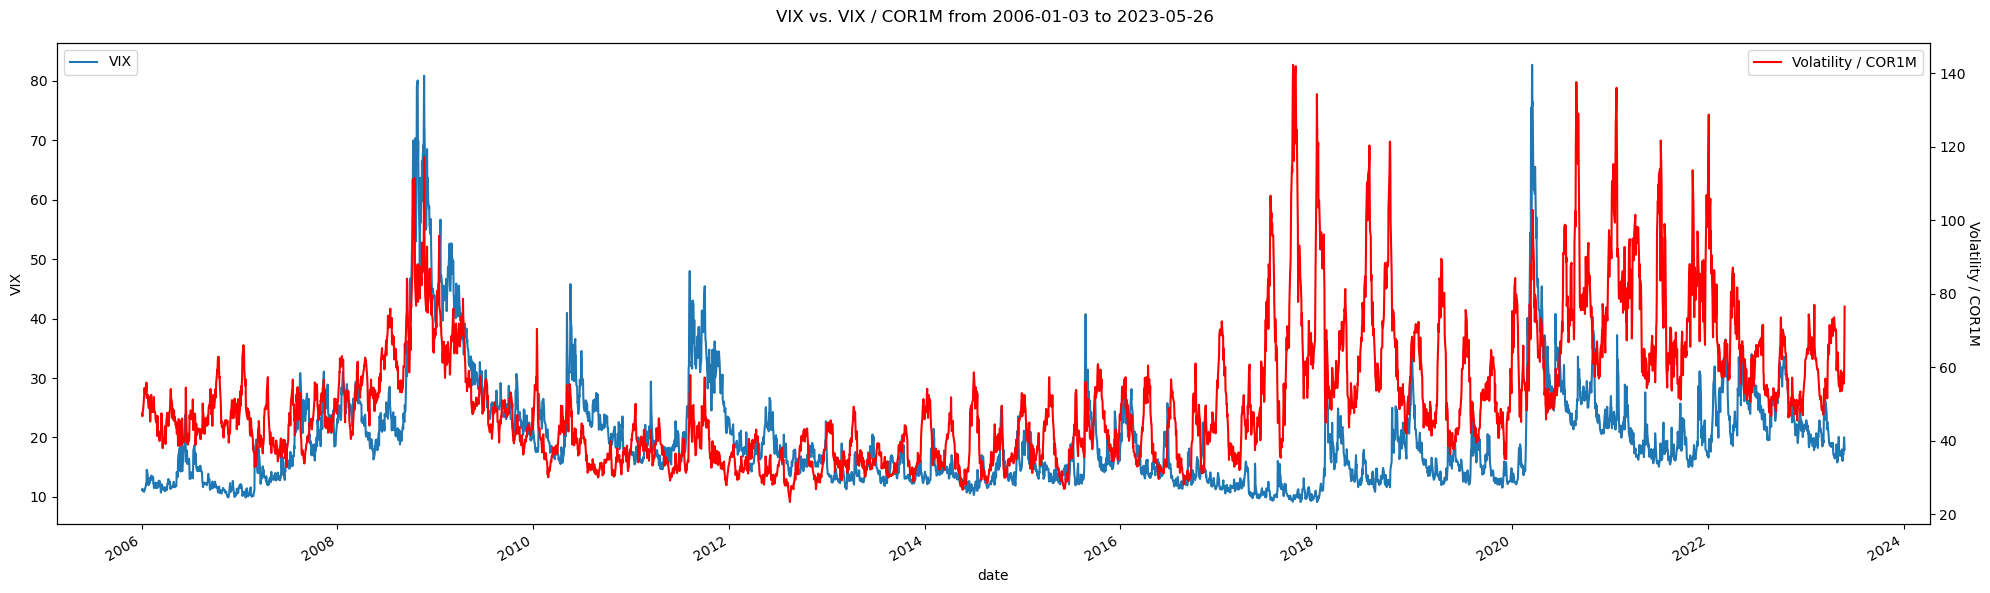

In [7]:
fig, axes = plt.subplots(figsize = FIGSIZE)
axes_copy = axes.twinx()

(df_vol_corr[[
    "volatility_measure"]].
    rename(columns = {"volatility_measure": "VIX"}).
    plot(ax = axes, ylabel = "VIX", label = "VIX"))

(df_vol_corr[
    ["vol_corr"]].
    rename(columns = {"vol_corr": "Volatility / COR1M"}).
    plot(ax = axes_copy, color = "red"))

axes_copy.set_ylabel("Volatility / COR1M", rotation = 270, labelpad = 10)
axes_copy.legend(loc = "upper right")
axes.legend(loc = "upper left")

fig.suptitle("VIX vs. VIX / COR1M from {} to {}".format(
    df_vol_corr.index.min().date(),
    df_vol_corr.index.max().date()))

plt.tight_layout()
plt.savefig(os.path.join(out_path, "vix_corr.jpeg"), dpi = 150)
plt.show()

In [8]:
df_yf_prep = (df_yf.pivot(
    index = "date", columns = "variable", values = "value").
    dropna())

df_corr_move = (df_vol_corr[
    ["vol_corr"]].
    reset_index().
    assign(name = "VIX/COR1M").
    pivot(index = "date", columns = "name", values = "vol_corr").
    reset_index().
    merge(df_yf_prep, how = "left", on = ["date"]).
    set_index("date"))

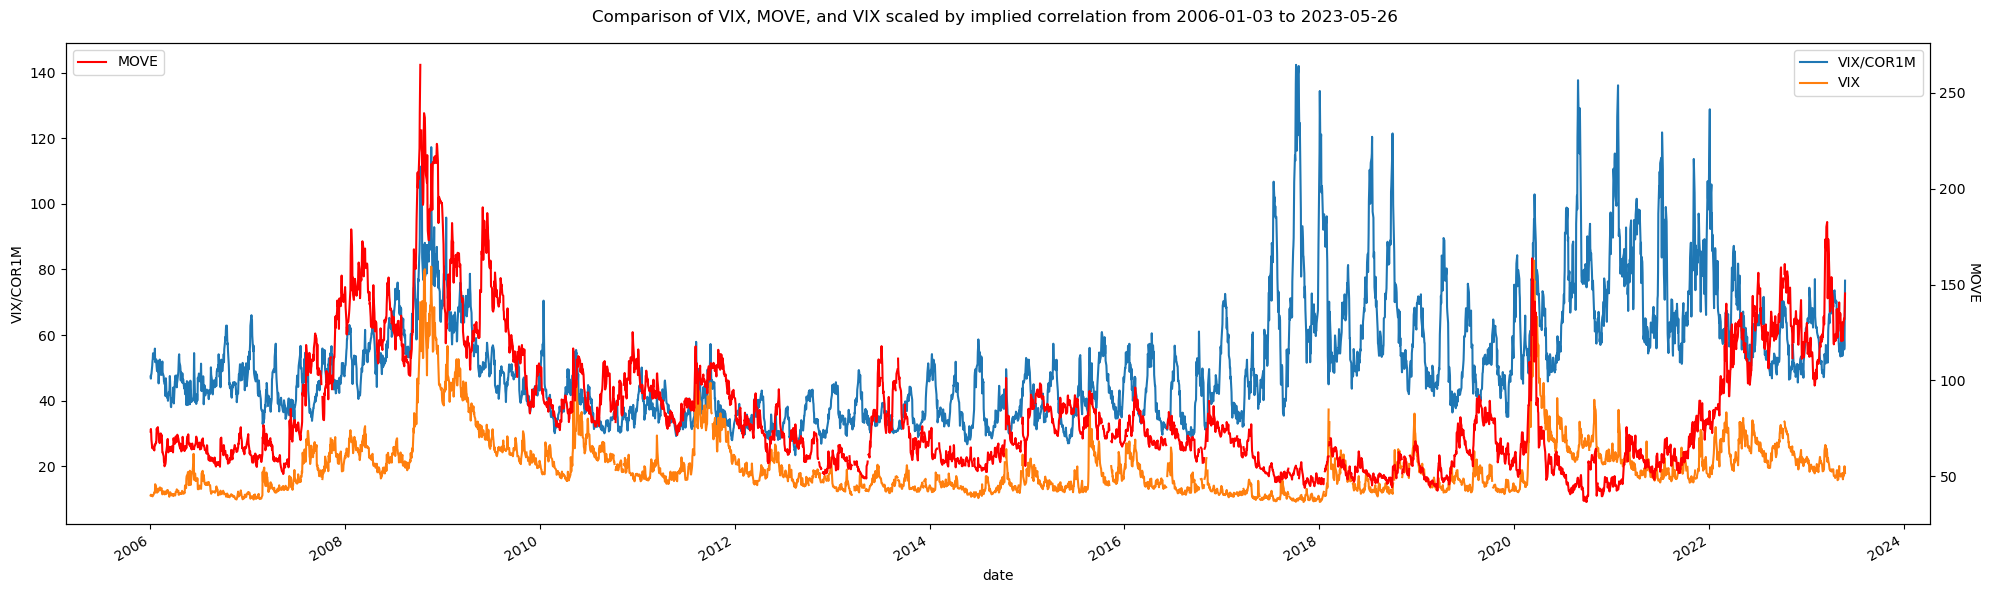

In [9]:
fig, axes = plt.subplots(figsize = FIGSIZE)

(df_corr_move[
    ["VIX/COR1M", "VIX"]].
    plot(
        ax = axes,
        ylabel = "VIX/COR1M"))

axes_twin = axes.twinx()
(df_corr_move[
    ["MOVE"]].
    plot(
        ax = axes_twin,
        color = "r"))
axes_twin.set_ylabel("MOVE", rotation = 270, labelpad = 10)
axes_twin.legend(loc = "upper left")

fig.suptitle("Comparison of VIX, MOVE, and VIX scaled by implied correlation from {} to {}".format(
    df_corr_move.index.min().date(), df_corr_move.index.max().date()))
plt.tight_layout()

# Let's look at the Z-score and the spread of the z-score

In [10]:
def _get_z_score(df):
    return(df.assign(
        df_rtn = lambda x: x.value.pct_change(),
        df_mean = lambda x: x.df_rtn.rolling(window = 120).mean(),
        df_std = lambda x: x.df_rtn.rolling(window = 120).std(),
        z_score = lambda x: (x.df_mean - x.df_rtn) / x.df_std).
        drop(columns = ["df_mean", "df_std", "df_rtn"]))

df_z_score = (df_corr_move.reset_index().melt(
    id_vars = "date").
    groupby("variable").
    apply(_get_z_score).
    drop(columns = ["value"]).
    pivot(index = "date", columns = "variable", values = "z_score").
    dropna())

In [11]:
df_z_score_spread = (df_z_score.rename(
    columns = {"VIX/COR1M": "vix_corr"}).
    assign(
        equity_rates = lambda x: x.MOVE - x.VIX,
        corr_rates = lambda x: x.MOVE - x.vix_corr)
    [["equity_rates", "corr_rates"]])

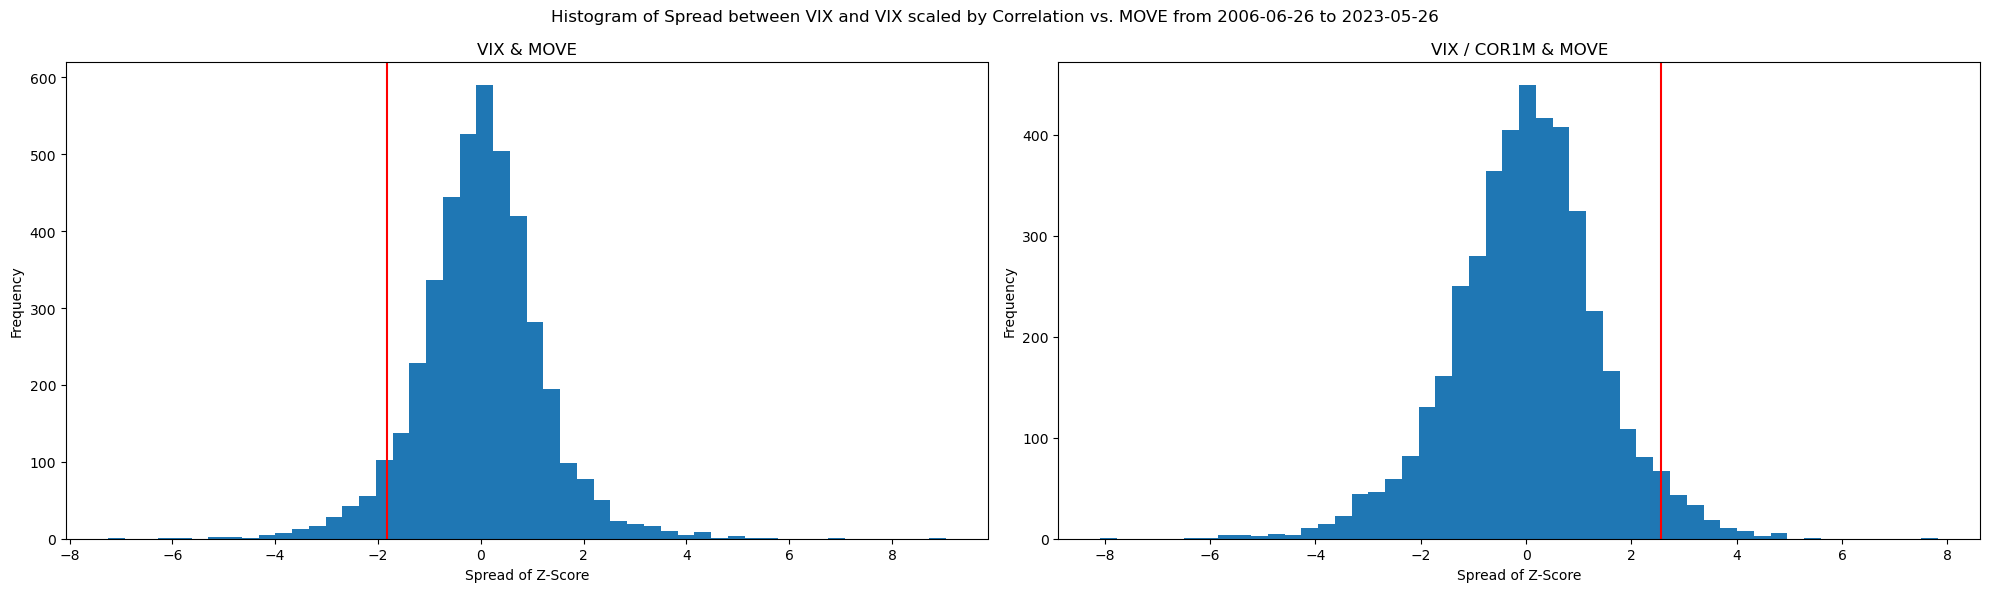

In [12]:
fig, axes = plt.subplots(ncols = 2, figsize = FIGSIZE)

(df_z_score_spread[
    ["equity_rates"]].
    plot(
        kind = "hist", ax = axes[0], bins = 50,
        legend = False,
        title = "VIX & MOVE"))

(df_z_score_spread[
    ["corr_rates"]].
    plot(
        kind = "hist", ax = axes[1], bins = 50,
        legend = False,
        title = "VIX / COR1M & MOVE"))

axes[0].set_xlabel("Spread of Z-Score")
axes[1].set_xlabel("Spread of Z-Score")

df_z_score_last = (df_z_score_spread.reset_index().query("date == date.max()"))
eq_rates_z_score = df_z_score_last.equity_rates.values[0]
corr_rates_z_score = df_z_score_last.corr_rates.values[0]

axes[0].axvline(
    eq_rates_z_score,
    color = "red")

axes[1].axvline(
    corr_rates_z_score,
    color = "red")

fig.suptitle("Histogram of Spread between VIX and VIX scaled by Correlation vs. MOVE from {} to {}".format(
    df_z_score_spread.index.min().date(),
    df_z_score_spread.index.max().date()))

plt.tight_layout()

# Regression

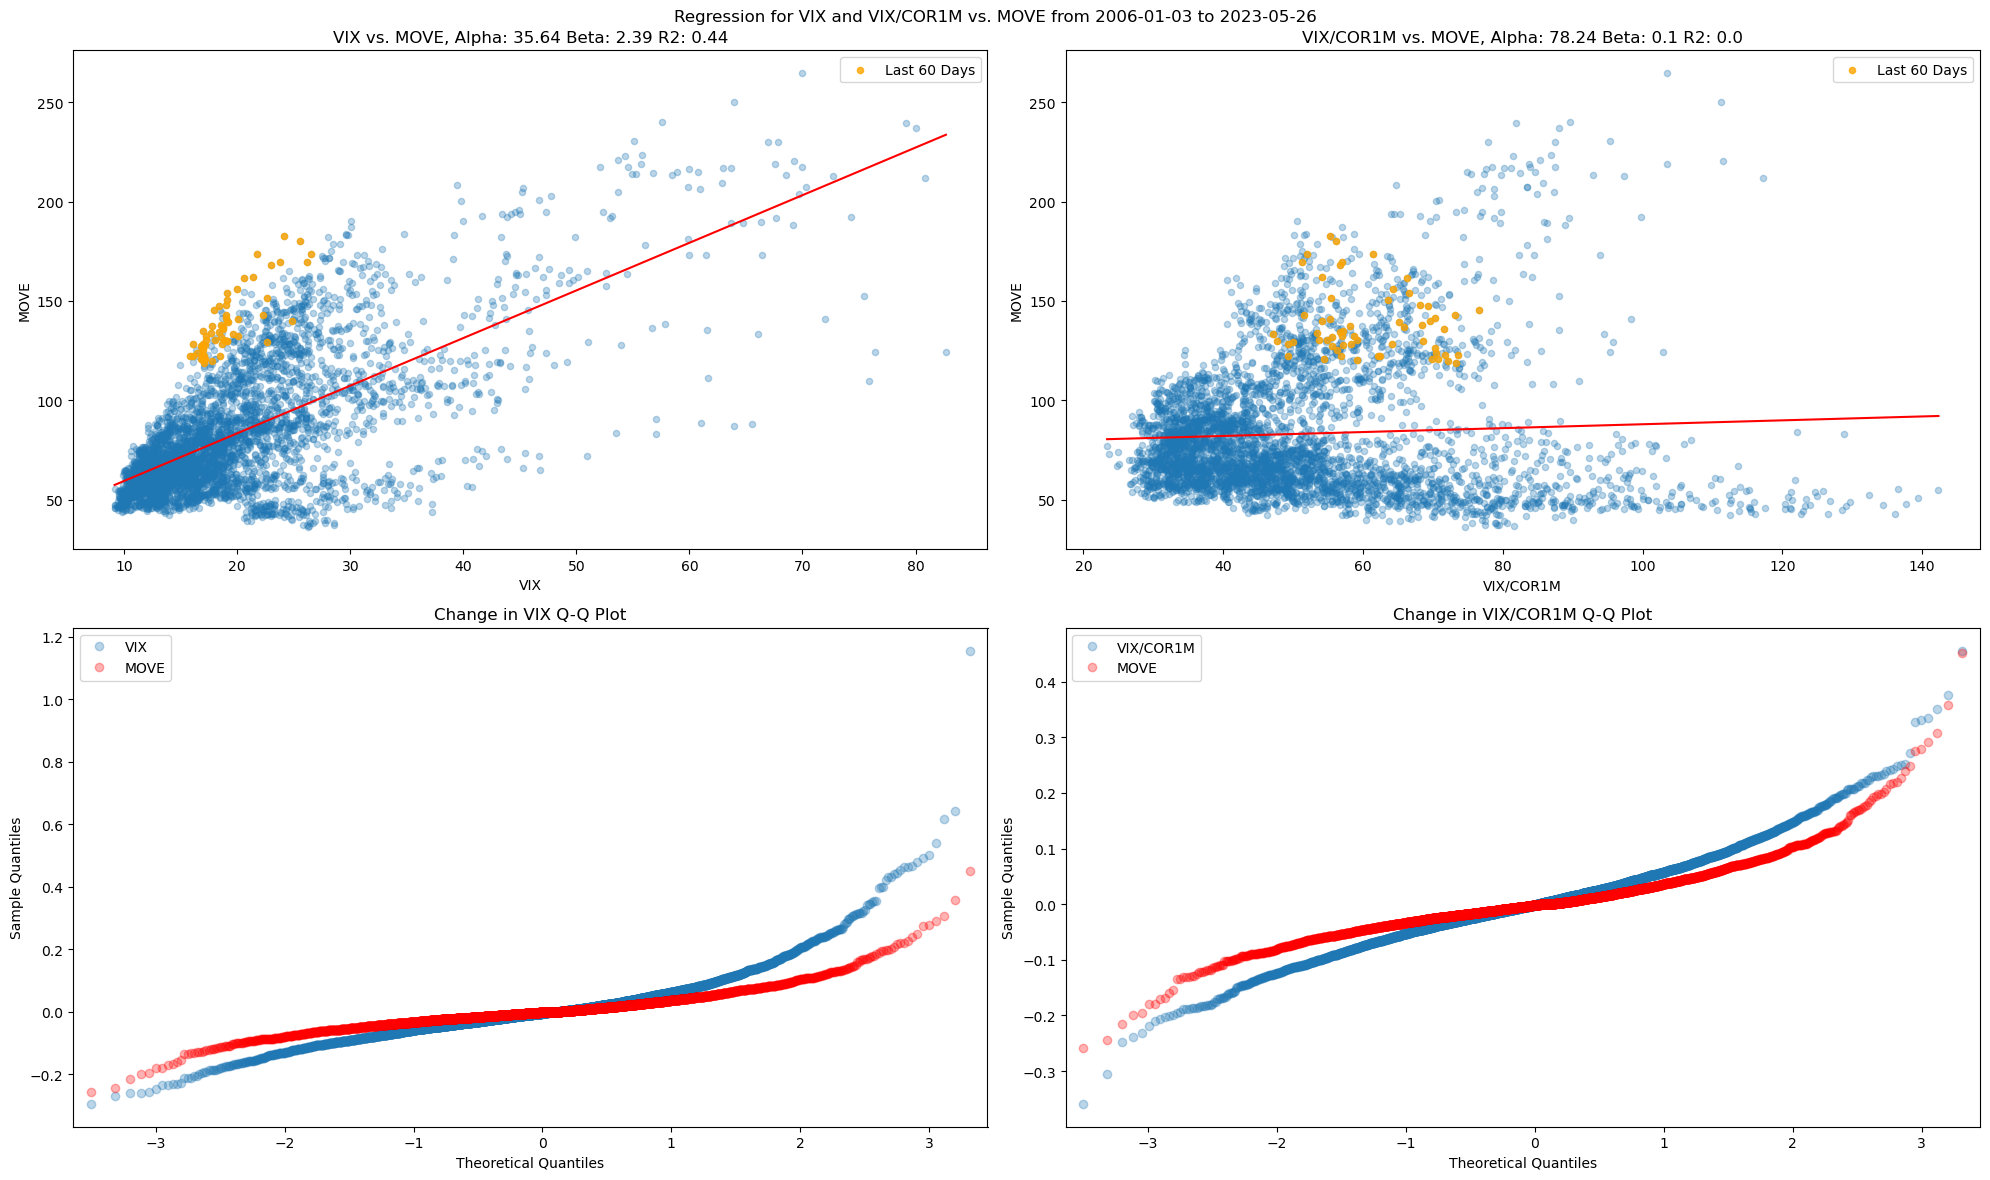

In [13]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (20, 12))

df_regress = df_corr_move.dropna()

regression1 = (sm.OLS(
    endog = df_regress.MOVE,
    exog = sm.add_constant(df_regress.VIX)).
    fit())

regression2 = (sm.OLS(
    endog = df_regress.MOVE,
    exog = sm.add_constant(df_regress["VIX/COR1M"])).
    fit())

alpha1, beta1 = regression1.params
alpha2, beta2 = regression2.params

x1 = np.linspace(
    start = df_corr_move.VIX.min(),
    stop = df_corr_move.VIX.max(),
    num = 1_000)

x2 = np.linspace(
    start = df_corr_move["VIX/COR1M"].min(),
    stop = df_corr_move["VIX/COR1M"].max(),
    num = 1_000)

y1 = (beta1 * x1) + alpha1
y2 = (beta2 * x2) + alpha2

(df_corr_move[
    ["VIX", "MOVE"]].
    plot(
        kind = "scatter", x = "VIX",  y = "MOVE",
        ax = axes[0,0],
        alpha = 0.3,
        title = "VIX vs. MOVE, Alpha: {} Beta: {} R2: {}".format(
            round(alpha1, 2),
            round(beta1, 2),
            round(regression1.rsquared, 2))))

(df_corr_move.sort_index().tail(60)[
    ["VIX", "MOVE"]].
    plot(
        kind = "scatter", x = "VIX", y = "MOVE",
        ax = axes[0,0],
        alpha = 0.8,
        color = "orange",
        label = "Last 60 Days"))

(df_corr_move[
    ["VIX/COR1M", "MOVE"]].
    plot(
        kind = "scatter", x = "VIX/COR1M",  y = "MOVE",
        ax = axes[0,1],
        alpha = 0.3,
        title = "VIX/COR1M vs. MOVE"))

(df_corr_move.sort_index().tail(60)[
    ["VIX/COR1M", "MOVE"]].
    plot(
        kind = "scatter", x = "VIX/COR1M",  y = "MOVE",
        ax = axes[0,1],
        color = "orange",
        alpha = 0.8,
        label = "Last 60 Days",
        title = "VIX/COR1M vs. MOVE, Alpha: {} Beta: {} R2: {}".format(
            round(alpha2, 2),
            round(beta2, 2),
            round(regression2.rsquared, 2))))

axes[0,0].plot(x1, y1, color = "r")
axes[0,1].plot(x2, y2, color = "r")

_ = sm.qqplot(
    df_corr_move["VIX"].pct_change(),
    ax = axes[1,0],
    alpha = 0.3,
    label = "VIX")

_ = sm.qqplot(
    df_corr_move["MOVE"].pct_change(),
    ax = axes[1,0],
    markerfacecolor = "r",
    markeredgecolor = "r",
    alpha = 0.3,
    label = "MOVE")

_ = sm.qqplot(
    df_corr_move["VIX/COR1M"].pct_change(),
    alpha = 0.3,
    ax = axes[1,1],
    label = "VIX/COR1M")

_ = sm.qqplot(
    df_corr_move["MOVE"].pct_change(),
    ax = axes[1,1],
    markerfacecolor = "r",
    markeredgecolor = "r",
    alpha = 0.3,
    label = "MOVE")

axes[1,0].legend()
axes[1,1].legend()

axes[1,0].set_title("Change in VIX Q-Q Plot")
axes[1,1].set_title("Change in VIX/COR1M Q-Q Plot")

fig.suptitle("Regression for VIX and VIX/COR1M vs. MOVE from {} to {}".format(
    df_corr_move.index.min().date(),
    df_corr_move.index.max().date()))

plt.tight_layout()
plt.show()

# Rolling Regression Expecting bad results

In [14]:
rolling_regression = (RollingOLS(
    endog = df_vol_corr.volatility_measure,
    exog = sm.add_constant(df_vol_corr.vol_corr),
    window = 30).
    fit())

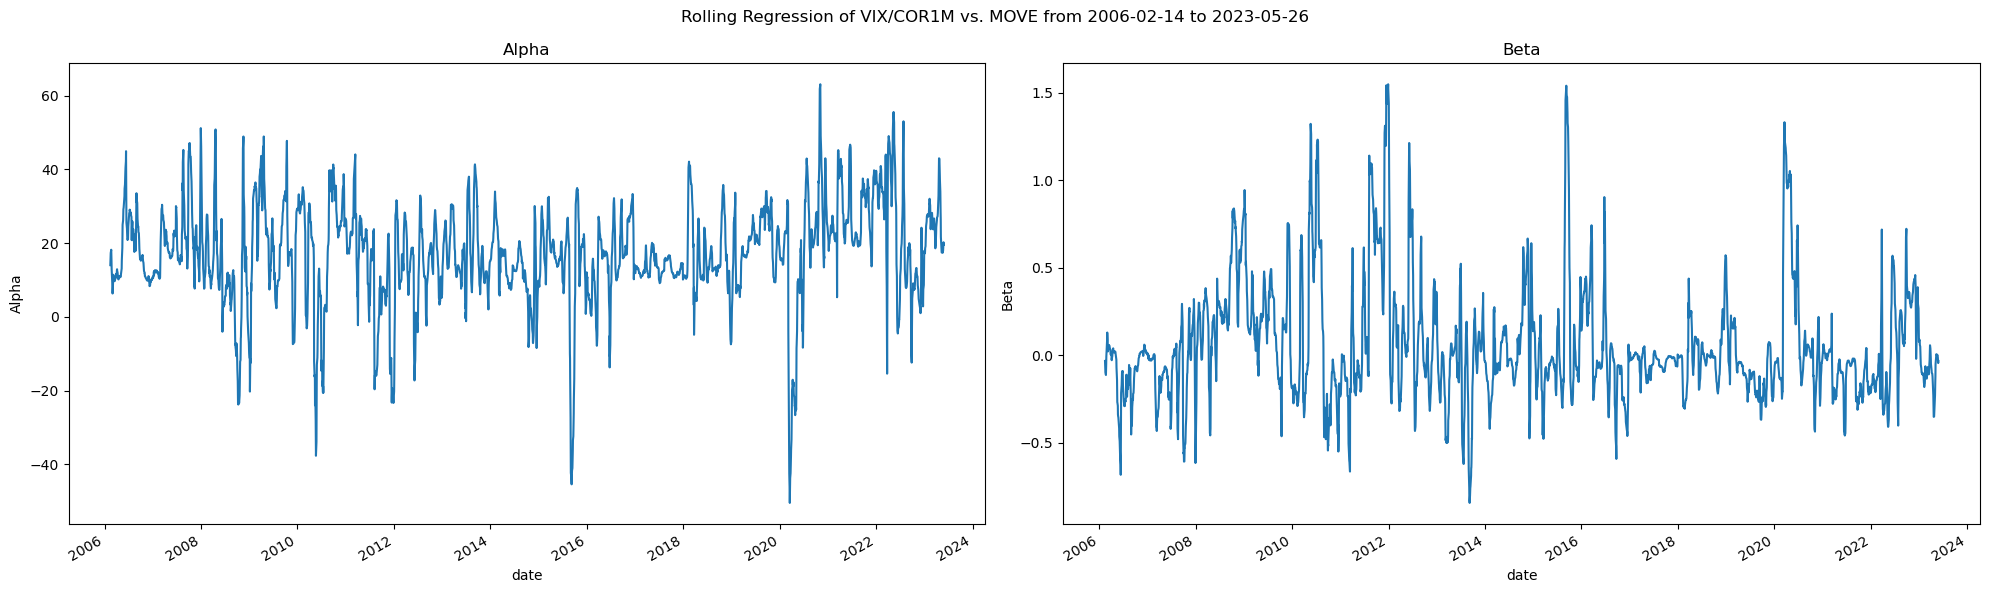

In [15]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 6))

df_params = (rolling_regression.params.rename(
    columns = {"const": "alpha", "vol_corr": "beta"}).
    dropna())

(df_params[
    ["alpha"]].
    plot(
        ax = axes[0],
        legend = False,
        title = "Alpha",
        ylabel = "Alpha"))

(df_params[
    ["beta"]].
    plot(
        ax = axes[1],
        legend = False,
        title = "Beta",
        ylabel = "Beta"))

fig.suptitle("Rolling Regression of VIX/COR1M vs. MOVE from {} to {}".format(
    df_params.index.min().date(), df_params.index.max().date()))
plt.tight_layout()
plt.show()

# Using Correlation solely

In [16]:
df_corr_move = (df_yf_prep.reset_index().merge(
    df_corr, how = "inner", on = ["date"]).
    drop(columns = ["ticker", "field"]).
    rename(columns = {"value": "corr"}).
    set_index("date"))

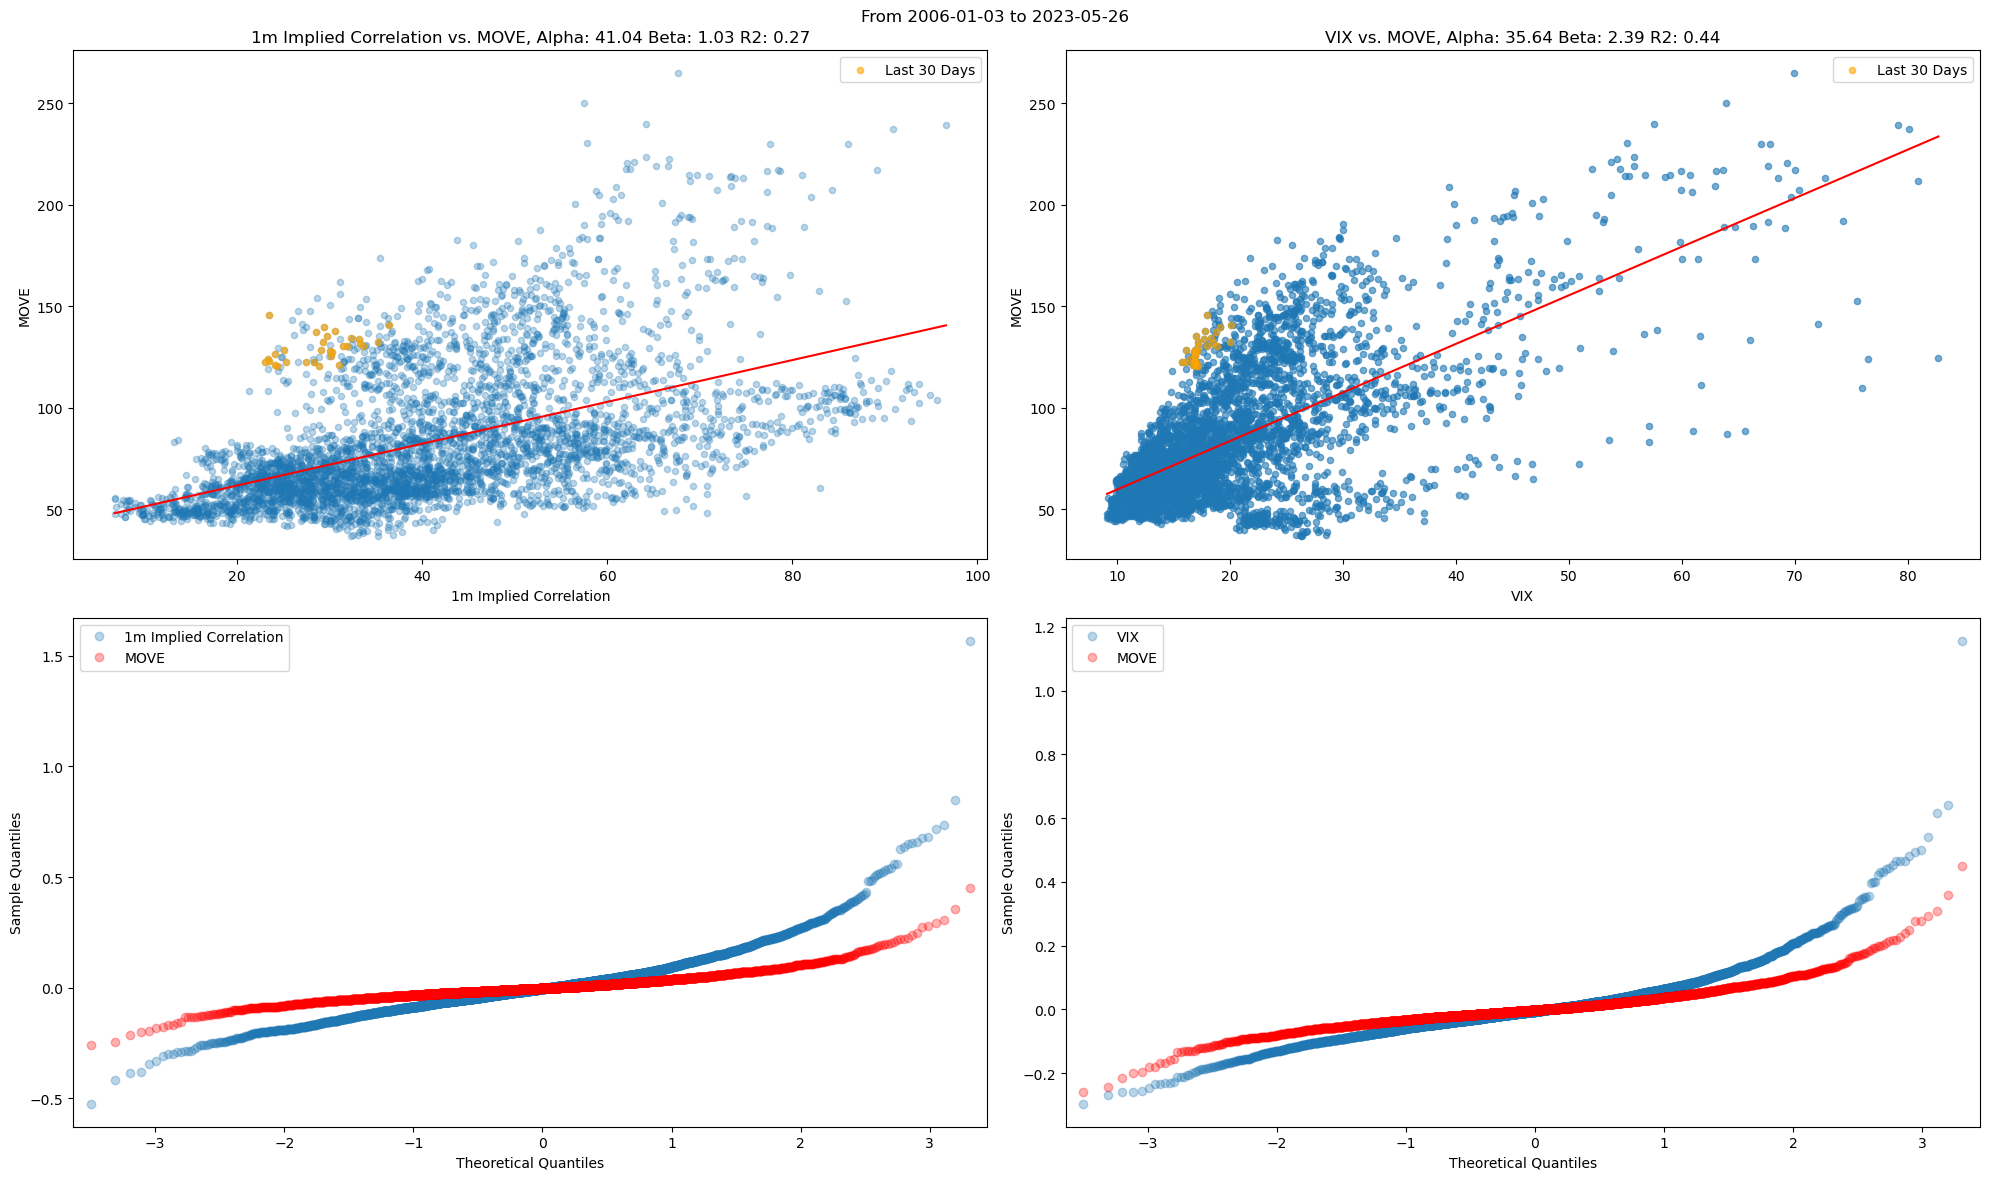

In [45]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (20, 12))

df_corr_move.plot(
    kind = "scatter", x = "corr", y = "MOVE",
    alpha = 0.3,
    ax = axes[0,0])

(df_corr_move.plot(
    kind = "scatter", x = "VIX", y = "MOVE",
    alpha = 0.6,
    ax = axes[0,1]))

regression1 = (sm.OLS(
    endog = df_corr_move.MOVE,
    exog = sm.add_constant(df_corr_move["corr"])).
    fit())

alpha1, beta1 = regression1.params
x1 = np.linspace(
    start = df_corr_move["corr"].min(),
    stop = df_corr_move["corr"].max(),
    num = 1_000)
y1 = (x1 * beta1) + alpha1 
axes[0,0].plot(x1, y1, color = "r")

regression2 = (sm.OLS(
    endog = df_corr_move.MOVE,
    exog = sm.add_constant(df_corr_move["VIX"])).
    fit())

alpha2, beta2 = regression2.params
x2 = np.linspace(
    start = df_corr_move.VIX.min(),
    stop = df_corr_move.VIX.max(),
    num = 1_000)
y2 = (x2 * beta2) + alpha2
axes[0,1].plot(x2, y2, color = "r")

df_corr_move.tail(30).plot(
    kind = "scatter", x = "corr", y = "MOVE",
    alpha = 0.6,
    color = "orange",
    ax = axes[0,0],
    label = "Last 30 Days",
    xlabel = "1m Implied Correlation",
    title = "1m Implied Correlation vs. MOVE, Alpha: {} Beta: {} R2: {}".format(
        round(alpha1, 2),
        round(beta1, 2),
        round(regression1.rsquared, 2)))

(df_corr_move.tail(30).plot(
    kind = "scatter", x = "VIX", y = "MOVE",
    alpha = 0.6,
    color = "orange",
    ax = axes[0,1],
    label = "Last 30 Days",
    title = "VIX vs. MOVE, Alpha: {} Beta: {} R2: {}".format(
        round(alpha2, 2),
        round(beta2, 2),
        round(regression2.rsquared, 2))))

_ = sm.qqplot(
    df_corr_move["VIX"].pct_change(),
    ax = axes[1,1],
    alpha = 0.3,
    label = "VIX")

_ = sm.qqplot(
    df_corr_move["MOVE"].pct_change(),
    ax = axes[1,1],
    markerfacecolor = "r",
    markeredgecolor = "r",
    alpha = 0.3,
    label = "MOVE")

_ = sm.qqplot(
    df_corr_move["corr"].pct_change(),
    ax = axes[1,0],
    alpha = 0.3,
    label = "1m Implied Correlation")

_ = sm.qqplot(
    df_corr_move["MOVE"].pct_change(),
    ax = axes[1,0],
    markerfacecolor = "r",
    markeredgecolor = "r",
    alpha = 0.3,
    label = "MOVE")

axes[1,0].legend()
axes[1,1].legend()

fig.suptitle("From {} to {}".format(
    df_corr_move.index.min().date(), df_corr_move.index.max().date()))
plt.tight_layout()

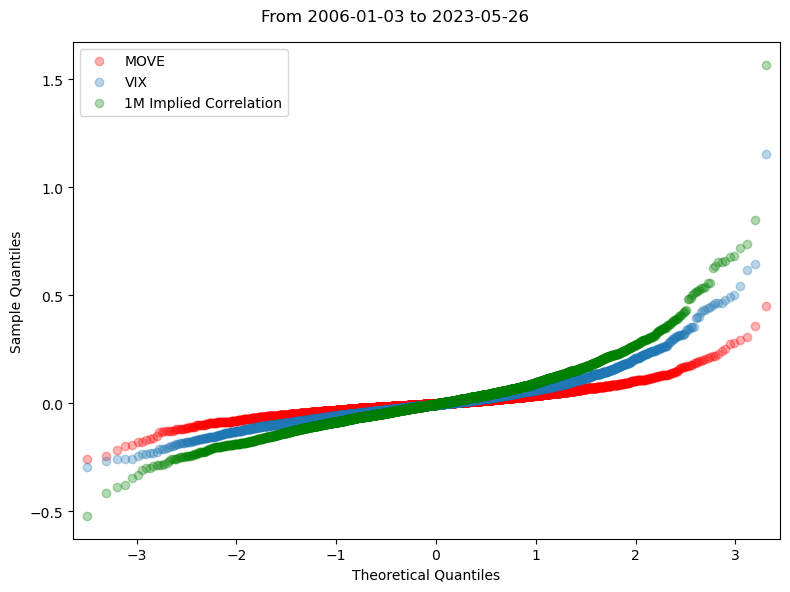

In [47]:
fig, axes = plt.subplots(figsize = (8, 6))

_ = sm.qqplot(
    df_corr_move["MOVE"].pct_change(),
    ax = axes,
    markerfacecolor = "r",
    markeredgecolor = "r",
    alpha = 0.3,
    label = "MOVE")

_ = sm.qqplot(
    df_corr_move["VIX"].pct_change(),
    ax = axes,
    alpha = 0.3,
    label = "VIX")

_ = sm.qqplot(
    df_corr_move["corr"].pct_change(),
    ax = axes,
    markerfacecolor = "g",
    markeredgecolor = "g",
    alpha = 0.3,
    label = "1M Implied Correlation")

axes.legend()
fig.suptitle("From {} to {}".format(
    df_corr_move.index.min().date(),
    df_corr_move.index.max().date()))

plt.tight_layout()
plt.show()

# Looking at the relationship between Correlation and VIX

In [52]:
df_vix_corr = (df_corr_move[
    ["VIX", "corr"]].
    rename(columns = {"corr": "correlation"}).
    assign(vix_corr = lambda x: x.VIX / x.correlation))

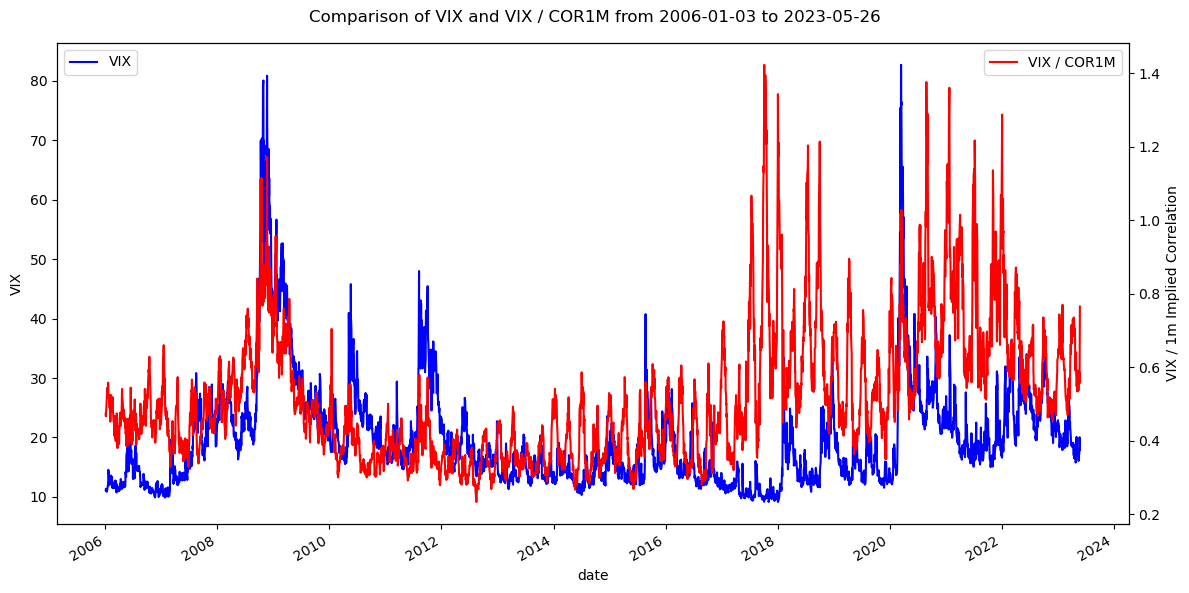

In [64]:
fig, axes = plt.subplots(figsize = (12, 6))

(df_vix_corr[
    ["VIX"]].
    plot(
        ax = axes,
        ylabel = "VIX",
        color = "b"))

axes_twinx = axes.twinx()

(df_vix_corr[
    ["vix_corr"]].
    rename(columns = {"vix_corr": "VIX / COR1M"}).
    plot(
        ax = axes_twinx,
        ylabel = "VIX / 1m Implied Correlation",
        color = "r"))

axes.legend(loc = "upper left")
axes_twinx.legend(loc = "upper right")

fig.suptitle("Comparison of VIX and VIX / COR1M from {} to {}".format(
    df_vix_corr.index.min().date(),
    df_vix_corr.index.max().date()))
plt.tight_layout()

Looking at their z-score

In [80]:
def _get_z_score(df: pd.DataFrame) -> pd.DataFrame:
    return(df.assign(
        z_score = lambda x: (x.value - x.value.rolling(window = 90).mean()) / x.value.rolling(window = 90).std()).
        dropna())

df_z_score = (df_vix_corr[
    ["VIX", "vix_corr"]].
    reset_index().
    melt(id_vars = "date").
    groupby("variable").
    apply(_get_z_score).
    drop(columns = ["value"]).
    pivot(index = "date", columns = "variable", values = "z_score").
    dropna())

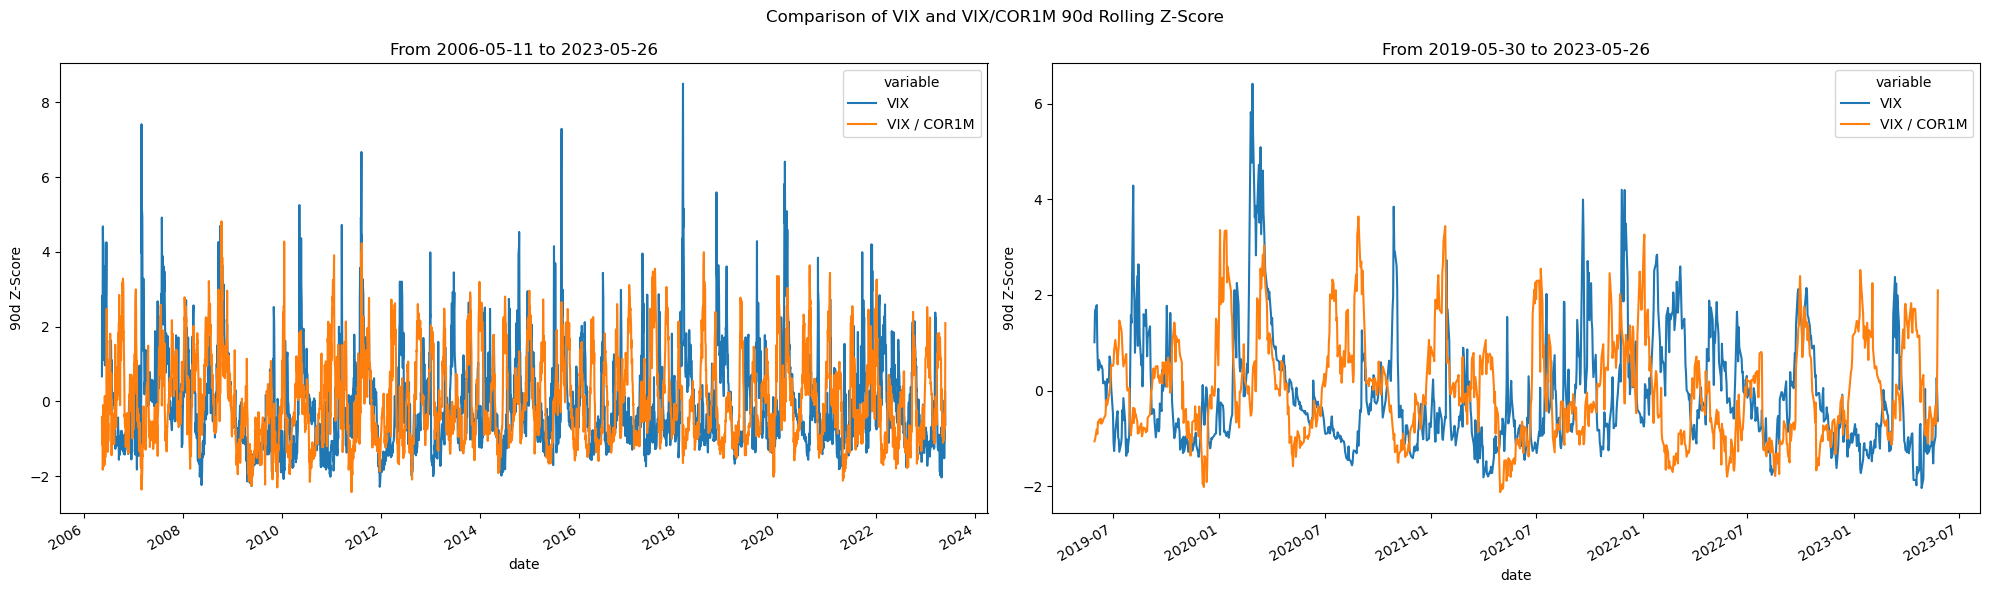

In [84]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

(df_z_score.
    rename(columns = {"vix_corr": "VIX / COR1M"}).
    plot(
        ax = axes[0],
        ylabel = "90d Z-Score",
        title = "From {} to {}".format(
            df_z_score.index.min().date(),
            df_z_score.index.max().date())))

(df_z_score.rename(
    columns = {"vix_corr": "VIX / COR1M"}).
    tail(1_000).
    plot(
        ax = axes[1],
        ylabel = "90d Z-Score",
        title = "From {} to {}".format(
            df_z_score.index[-1_000].date(),
            df_z_score.index.max().date())))

fig.suptitle("Comparison of VIX and VIX/COR1M 90d Rolling Z-Score")
plt.tight_layout()
plt.show()

Spread of Z-Scores

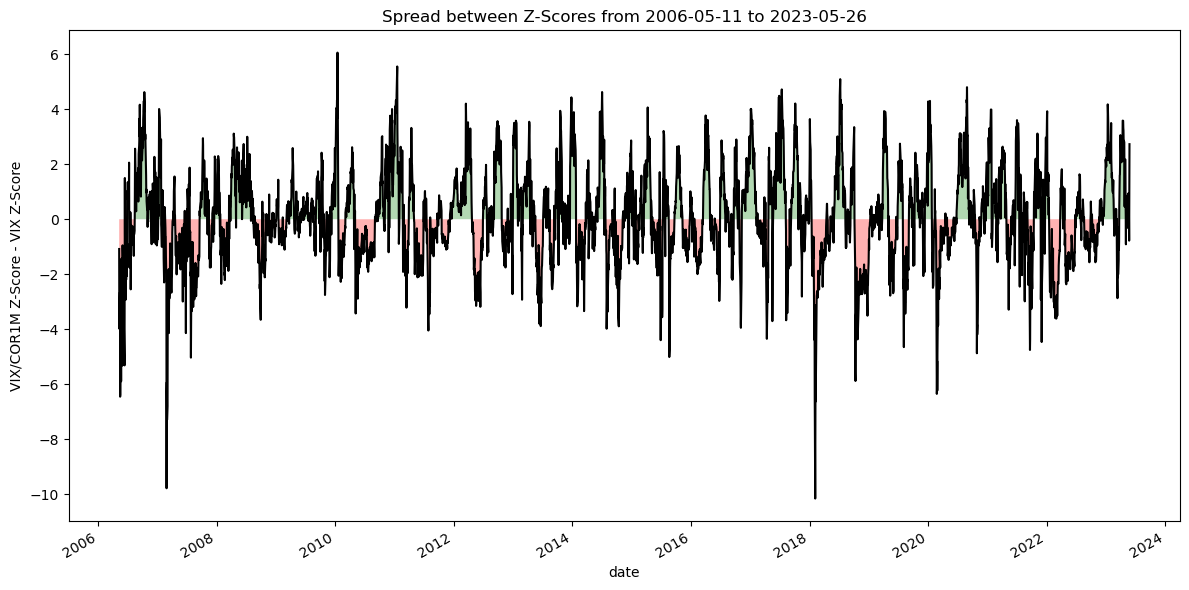

In [88]:
fig, axes = plt.subplots(figsize = (12,6))

df_z_score_spread = (df_z_score.assign(
    spread = lambda x: x.vix_corr - x.VIX).
    drop(columns = ["VIX", "vix_corr"]))

(df_z_score_spread.plot(
    ax = axes,
    ylabel = "VIX/COR1M Z-Score - VIX Z-Score",
    color = "black",
    legend = False,
    title = "Spread between Z-Scores from {} to {}".format(
        df_z_score.index.min().date(),
        df_z_score.index.max().date())))

axes.fill_between(
    x = df_z_score_spread.index,
    y1 = df_z_score_spread.spread,
    y2 = 0,
    where = df_z_score_spread.spread > 0,
    facecolor = "green",
    alpha = 0.3)

axes.fill_between(
    x = df_z_score_spread.index,
    y1 = df_z_score_spread.spread,
    y2 = 0,
    where = df_z_score_spread.spread < 0,
    facecolor = "red",
    alpha = 0.3)

plt.tight_layout()
plt.show()

Need to do regression on realized volatilty vs. all of these